In [7]:
# Topic modeling script for AI impact on employment analysis
# Set random seed for reproducibility
import numpy as np
np.random.seed(42)

import os
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [8]:
# Create cache directory if it doesn't exist
cache_dir = "cache"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

def get_cache_path(filename):
    """Get full path for a cache file"""
    return os.path.join(cache_dir, filename)

def save_to_cache(obj, filename):
    """Save object to cache"""
    with open(get_cache_path(filename), 'wb') as f:
        pickle.dump(obj, f)

def load_from_cache(filename):
    """Load object from cache if it exists"""
    cache_path = get_cache_path(filename)
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            return pickle.load(f)
    return None

In [9]:
# Try loading from each of the possible cache files
df_clean = None
cache_files = ["cleaned_data_for_lda.pkl", "cleaned_data_minimal.pkl", "cleaned_data.pkl"]

for cache_file in cache_files:
    print(f"Attempting to load {cache_file}...")
    try:
        df_clean = load_from_cache(cache_file)
        if df_clean is not None and 'cleaned_text' in df_clean.columns:
            print(f"Successfully loaded data from {cache_file}")
            print(f"DataFrame shape: {df_clean.shape}")
            print(f"Columns: {df_clean.columns.tolist()}")
            break
        else:
            if df_clean is None:
                print(f"File {cache_file} not found or could not be loaded")
            else:
                print(f"File {cache_file} loaded but 'cleaned_text' column is missing")
            df_clean = None
    except Exception as e:
        print(f"Error loading {cache_file}: {e}")
        df_clean = None

if df_clean is None:
    print("ERROR: Could not load valid data from any cache file!")
    print("Please run clean_and_filter.py first to generate the necessary data files.")
    # Don't use exit() in notebooks
else:
    print(f"Data loaded with {len(df_clean)} articles")

Attempting to load cleaned_data_for_lda.pkl...
Successfully loaded data from cleaned_data_for_lda.pkl
DataFrame shape: (184391, 11)
Columns: ['url', 'date', 'language', 'title', 'text', 'cleaned_text', 'year', 'month', 'yearmonth', 'is_relevant', 'source_domain']
Data loaded with 184391 articles


In [10]:
def run_topic_modeling(df_input, num_topics=10, force_recompute=False):
    """
    Run topic modeling on articles
    
    Args:
        df_input: DataFrame with cleaned articles (must contain 'cleaned_text' column)
        num_topics: Number of topics to extract
        force_recompute: Whether to force recomputation
        
    Returns:
        Tuple of (topic_model, document_topics, feature_names)
    """
    if df_input is None:
        print("ERROR: Input DataFrame is None!")
        return None, None, None, None
        
    if 'cleaned_text' not in df_input.columns:
        print("ERROR: Input DataFrame has no 'cleaned_text' column!")
        print(f"Available columns: {df_input.columns.tolist()}")
        return None, None, None, None
    
    cache_file = f"topic_model_{num_topics}.pkl"
    
    # Results
    if not force_recompute:
        cached_data = load_from_cache(cache_file)
        if cached_data is not None:
            print("Loaded topic model from cache")
            return cached_data
    
    print("Running topic modeling...")
    
    documents = df_input['cleaned_text'].tolist()
    if not documents:
        print("ERROR: No documents found in the cleaned_text column!")
        return None, None, None, None
    
    # Use CountVectorizer with n-grams
    print("Creating document-term matrix...")
    vectorizer = CountVectorizer(
        max_df=0.7,
        min_df=10,
        max_features=10000,
        ngram_range=(1, 2),
        stop_words='english'
    )
    
    # Create document-term matrix
    try:
        X = vectorizer.fit_transform(documents)
        feature_names = vectorizer.get_feature_names_out()
    except Exception as e:
        print(f"Error in vectorization: {e}")
        # Return placeholder if we encounter an error
        return None, np.array([0] * len(documents)), [], []
    
    # Train LDA model
    print(f"Training LDA model with {num_topics} topics...")
    lda = LatentDirichletAllocation(
        n_components=num_topics,
        max_iter=10,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit model and transform documents
    try:
        doc_topic_dists = lda.fit_transform(X)
        
        # Get the most probable topic for each document
        doc_topics = doc_topic_dists.argmax(axis=1)
        
        # Extract top terms for each topic
        topic_terms = []
        for topic_idx, topic in enumerate(lda.components_):
            top_features_ind = topic.argsort()[:-10 - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            topic_terms.append(top_features)
        
        # Save topic model, document topics, and feature names
        result = (lda, doc_topics, feature_names, topic_terms)
        save_to_cache(result, cache_file)
        
        return result
    except Exception as e:
        print(f"Error in topic modeling: {e}")
        return None, np.array([0] * len(documents)), [], []

def plot_topics(lda, feature_names, n_top_words=10, save_path=None):
    """
    Plot the top words for each topic in the LDA model
    
    Args:
        lda: Trained LDA model
        feature_names: Names of features from vectorizer
        n_top_words: Number of top words to show per topic
        save_path: Path to save the figure, if None just displays
    """
    fig, axes = plt.subplots(5, 2, figsize=(15, 25), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(lda.components_):
        if topic_idx >= len(axes):
            break
            
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights)
        ax.set_title(f'Topic {topic_idx + 1}', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xlabel('Weight', fontsize=14)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    return fig

def plot_topics_over_time(df, topics, topic_terms, top_n_topics=5, save_path=None):
    """Plot the prevalence of top topics over time"""
    # Create DataFrame with topics
    topic_df = pd.DataFrame({'date': df['date'], 'topic': topics})
    
    # Counts of each topic
    topic_counts = {}
    for topic in range(max(topics) + 1):
        topic_counts[topic] = np.sum(topics == topic)
    
    # Get top topics
    top_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
    top_topics = [topic for topic, count in top_topics[:top_n_topics]]
    
    # Top topics by month
    topic_df = topic_df[topic_df['topic'].isin(top_topics)]
    topic_df['yearmonth'] = topic_df['date'].dt.strftime('%Y-%m')
    
    # Topics per month
    topic_time = topic_df.groupby(['yearmonth', 'topic']).size().reset_index(name='count')
    
    # Datetime
    topic_time['date'] = pd.to_datetime(topic_time['yearmonth'] + '-01')
    topic_time = topic_time.sort_values('date')
    
    # Create pivot table
    pivot_df = topic_time.pivot(index='date', columns='topic', values='count').fillna(0)
    
    # Add topic labels from terms
    topic_labels = {}
    for topic in top_topics:
        # Label from top 3 words
        label = ', '.join(topic_terms[topic][:3])
        topic_labels[topic] = f"Topic {topic}: {label}"
    
    plt.figure(figsize=(12, 6))
    
    if topic_labels:
        pivot_df = pivot_df.rename(columns=topic_labels)
    
    pivot_df.plot(kind='line', figsize=(12, 6))
    plt.title('Top Topics Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Article Count', fontsize=14)
    plt.legend(title='Topic', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    return plt.gcf()

Starting topic modeling...
Running topic modeling...
Creating document-term matrix...
Training LDA model with 10 topics...
Creating topic visualizations...
Topic modeling and visualization complete!
Saved topic visualization to 'topic_words.png'
Saved topics over time to 'topics_over_time.png'
Saved enriched data to cache as 'data_with_topics.pkl'


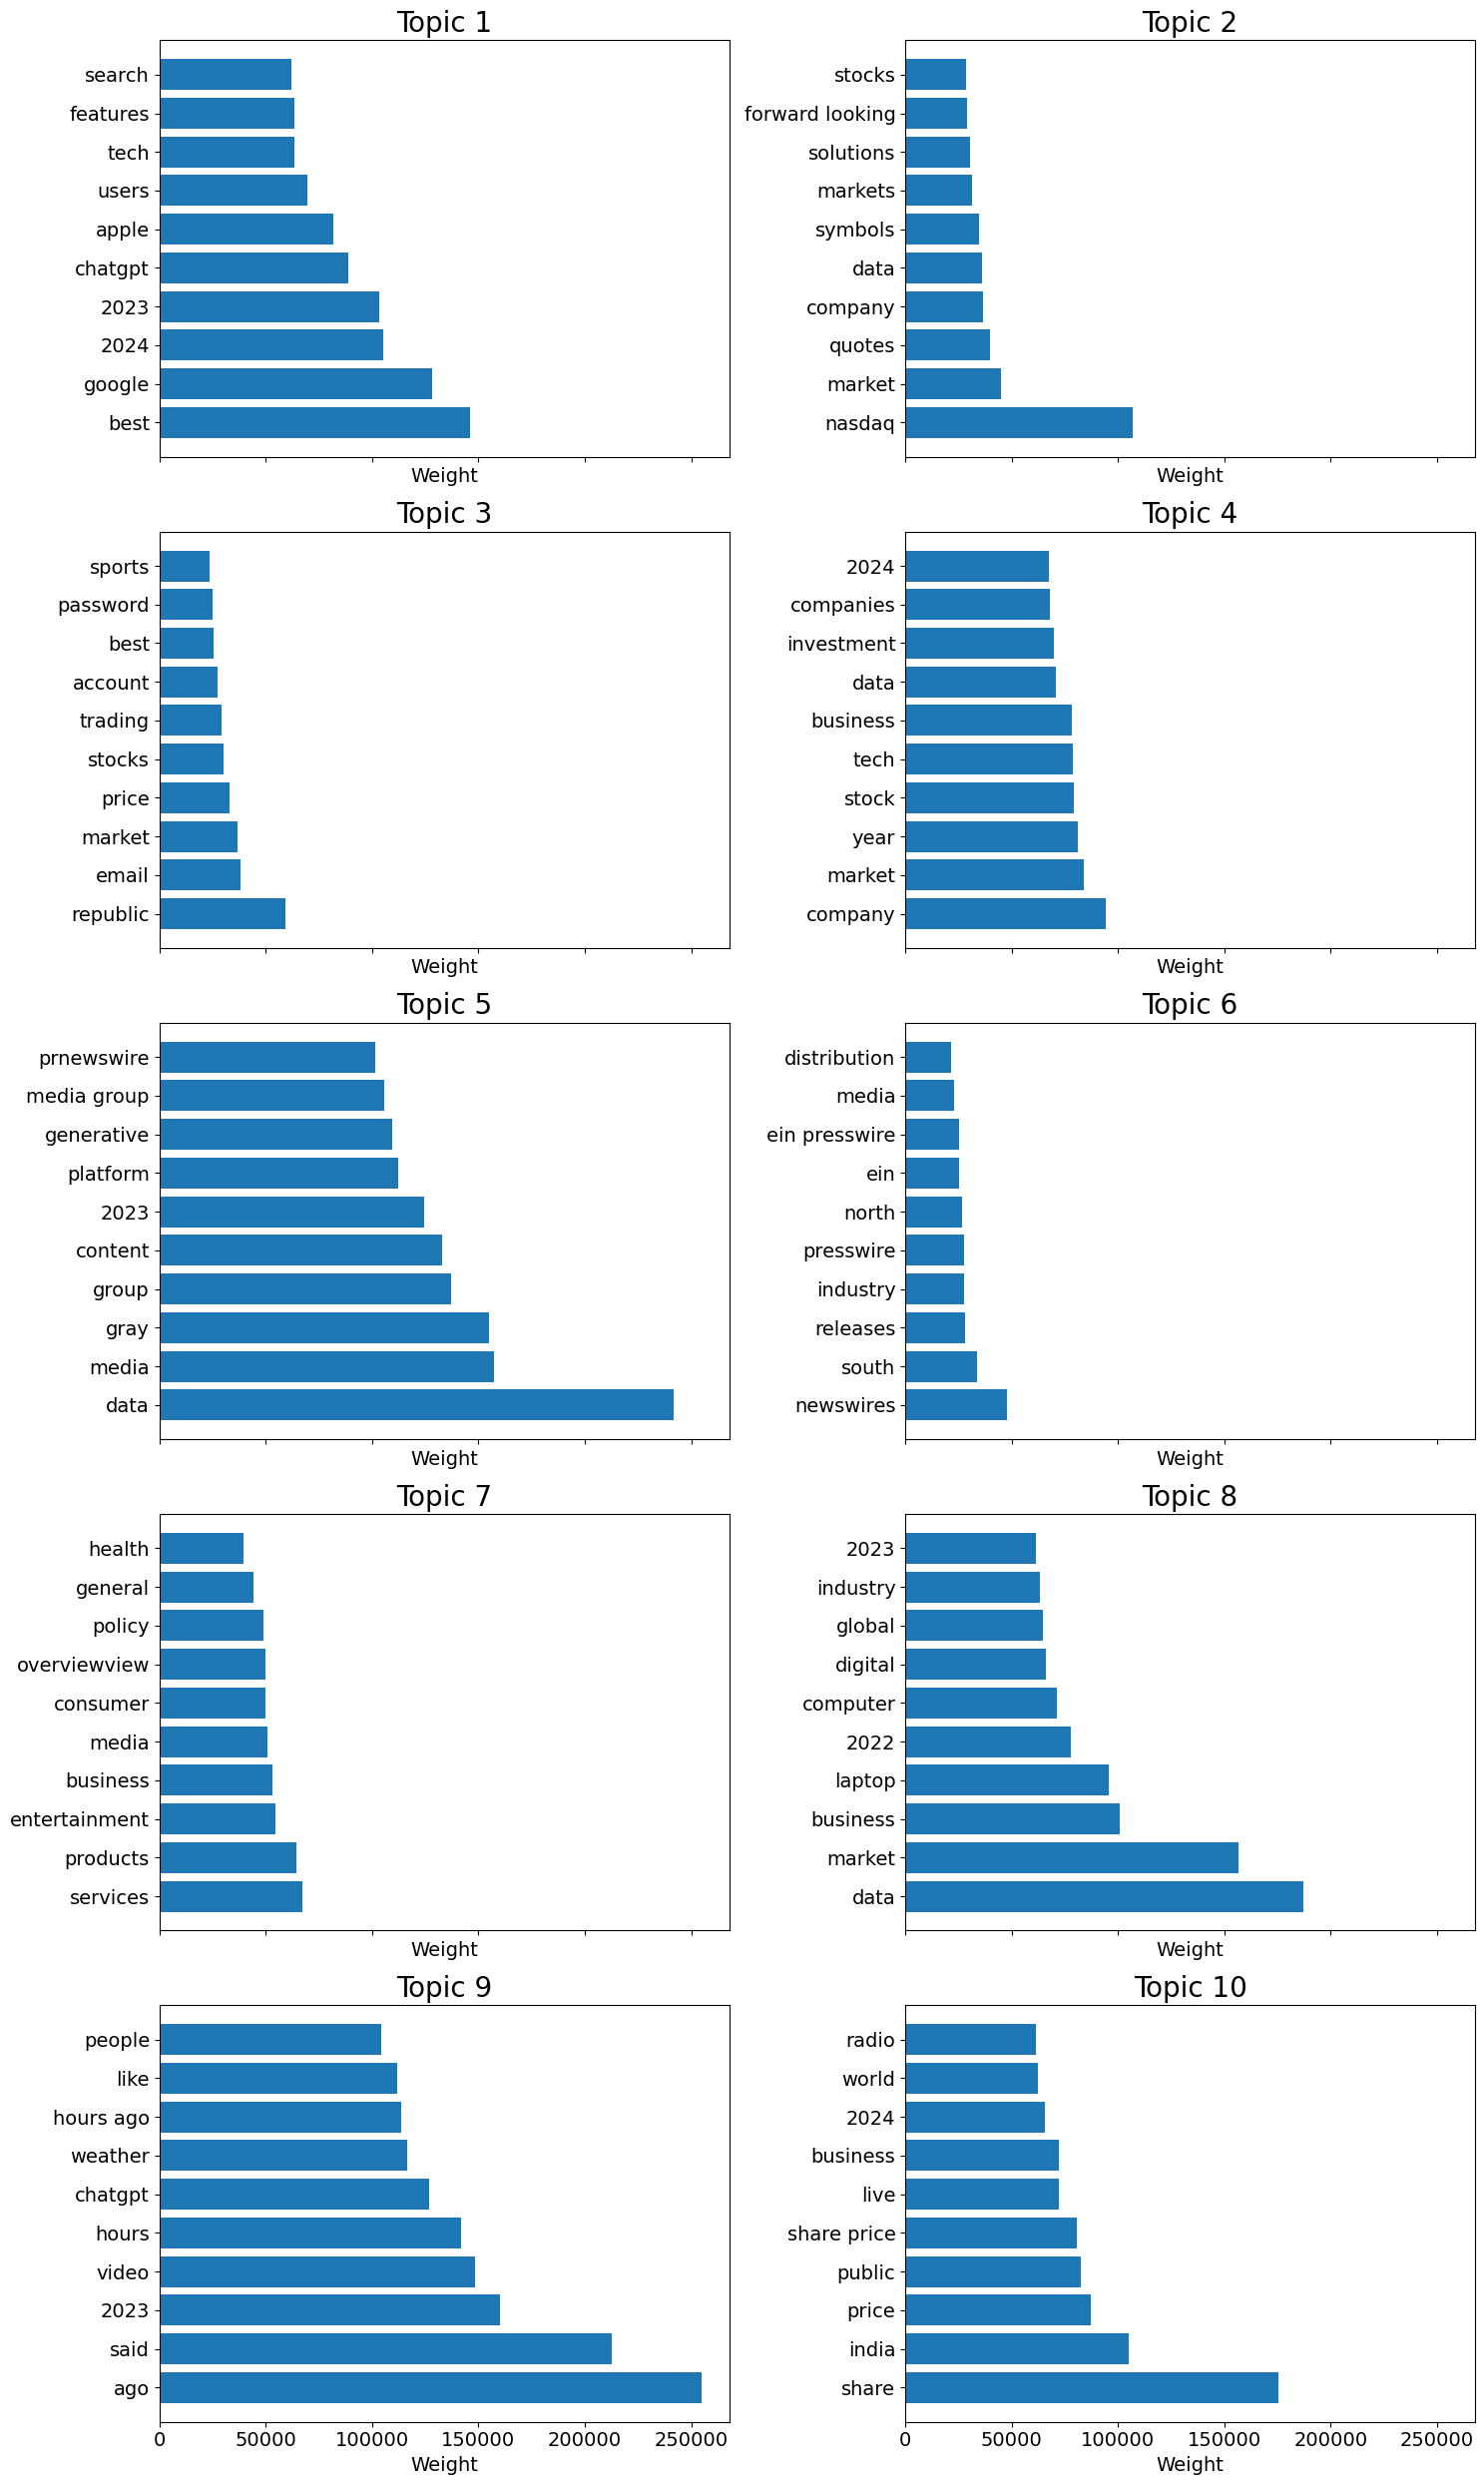

<Figure size 1200x600 with 0 Axes>

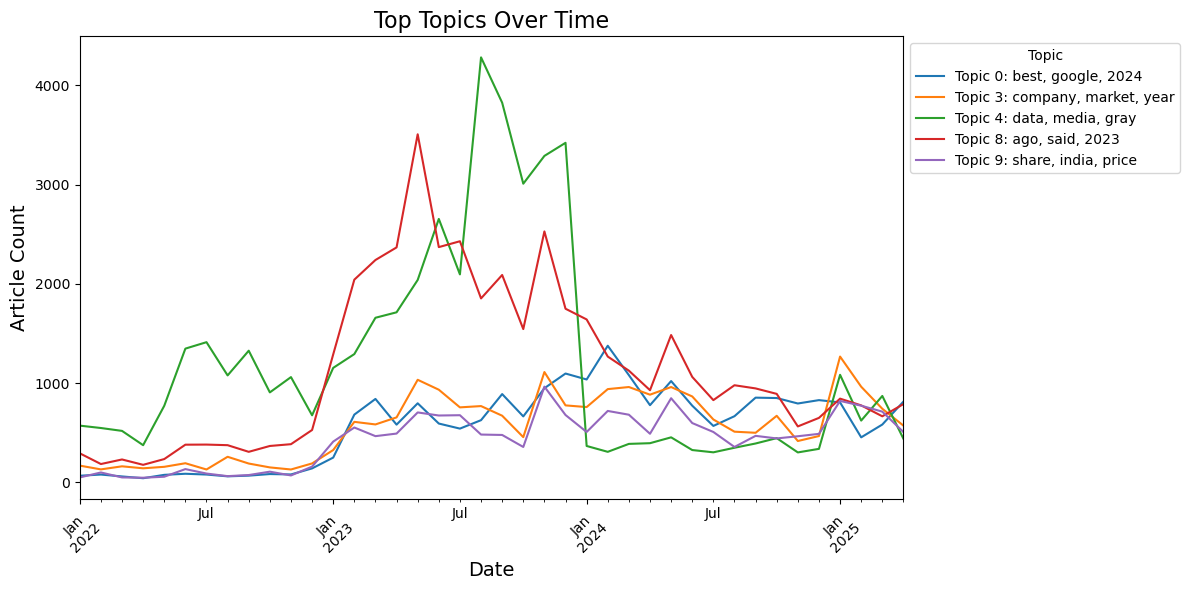

In [11]:
if df_clean is not None:
    # Run topic modeling
    print("Starting topic modeling...")
    lda, doc_topics, feature_names, topic_terms = run_topic_modeling(
        df_clean, 
        num_topics=10, 
        force_recompute=True
    )
    
    if lda is not None:
        # Add topic to each document
        df_clean['topic'] = doc_topics
        
        print("Creating topic visualizations...")
        
        # Plot top words for each topic
        fig1 = plot_topics(lda, feature_names, n_top_words=10, save_path="topic_words.png")
        
        # Plot topics over time
        fig2 = plot_topics_over_time(df_clean, doc_topics, topic_terms, top_n_topics=5, save_path="topics_over_time.png")
        
        # Save the enriched DataFrame with topics
        save_to_cache(df_clean, "data_with_topics.pkl")
        
        print("Topic modeling and visualization complete!")
        print("Saved topic visualization to 'topic_words.png'")
        print("Saved topics over time to 'topics_over_time.png'")
        print("Saved enriched data to cache as 'data_with_topics.pkl'")
    else:
        print("ERROR: Topic modeling failed!")
else:
    print("Cannot run topic modeling because no valid data was loaded.")